In [1]:
import pandas as pd
import torchaudio
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pipetorch.train import *
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import math
from torch.utils.data import WeightedRandomSampler

all gpu's are busy, please use a CPU or try again later


## Some preparation

In [2]:
df = pd.read_csv('../../data/dataset_tensors_melspec/train/audio_train_augmented_melspec_tensors.csv')
df

,filename,modification,label
0,-4wthmfwlwQ_260.pt,None,chewing
1,-5IpgOv9HD0_30.pt,None,chewing
2,-KO1p22zjVc_470.pt,None,chewing
3,-t-lmWNCXt0_10.pt,None,chewing
4,-t95P0R9Pf0_60.pt,None,chewing
...,...,...,...
7827,4gBf0FWwKnQ_100_squeezed.pt,squeezed,other
7828,4gBf0FWwKnQ_100_extended.pt,extended,other
7829,4gBf0FWwKnQ_100_shiftRight.pt,shiftRight,other
7830,4gBf0FWwKnQ_100_shiftLeft.pt,shiftLeft,other


In [3]:
class AudioSet(Dataset):
    def __init__(self, df, root_dir, in_col, out_col, length_sec, sampling_rate):
        self.df = df
        self.root_dir = root_dir
        self.in_col = in_col
        self.out_col = out_col
        self.length_sec = length_sec
        self.sampling_rate = sampling_rate
        
        self.c2i = {'chewing': 0, 'drinking': 1, 'other': 2}
        self.i2c = {0: 'chewing', 1: 'drinking', 2: 'other'}
        
    def __getitem__(self, index):
        filepath = self.root_dir + self.df.iloc[index][self.in_col]
        data = torch.load(filepath)
        label = self.c2i[self.df.iloc[index][self.out_col]]
        return data.cuda(), label
        
    def __len__(self):
        return len(self.df)

In [4]:
def my_precision_score(true_y, pred_y):
    return precision_score(true_y, pred_y, average=None)

In [5]:
def my_recall_score(true_y, pred_y):
    return recall_score(true_y, pred_y, average=None)

In [25]:
def sort_epochs(results, by):
    results = results[results['phase'] != '']
    results[['prec_chewing', 'prec_drinking', 'prec_other']] = pd.DataFrame(results['my_precision_score'].tolist(), index=results.index)
    results[['recall_chewing', 'recall_drinking', 'recall_other']] = pd.DataFrame(results['my_recall_score'].tolist(), index=results.index)

    results = results[results['phase'] == 'valid']
    results = results.sort_values(by, ascending=False)
    print(results[['accuracy_score', 'epoch', 'prec_chewing', 'prec_drinking', 'recall_chewing', 'recall_drinking']])

In [7]:

# thanks to https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# modified the function a little to fit our needs

def make_confusion_matrix(true_y,
                          pred_y,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''
    
    cf = confusion_matrix(true_y, pred_y)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [round(value / np.sum(cf[i // 3]) * 100, 2) for i, value in enumerate(cf.flatten())]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}%".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))


        #Metrics for Binary Confusion Matrices
        precision = precision_score(true_y, pred_y, average=None)
        
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision Chewing={:0.3f}\n Precision Drinking={:0.3f}\n".format(
            accuracy, precision[0], precision[1])
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    
    group_percentages = np.reshape(group_percentages, (3, 3))

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        group_percentages,annot=box_labels,
        fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,
        yticklabels=categories, vmin=0, vmax=100)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [8]:
c2i = {'chewing': 0, 'drinking': 1, 'other': 2}

def predict_test_set(model, df_test, audio_dir, print_wrong=True, gpu=True):
    model = model.cuda() if gpu else model.cpu()
    
    # get labels and filenames
    true_y = [c2i[label] for label in df_test['label'].values]
    filenames = df_test['filename'].values
    pred_y = []
    
    for filename in filenames:
        t = torch.load(audio_dir + filename)
        t = t.cuda() if gpu else t.cpu()
        t = t[None, :] # expand the tensor
        
        with torch.no_grad():
            pred = model(t)
            pred = model.post_forward(pred)
            pred_y.append(pred.data.cpu().numpy()[0])
    # plot conf matrix
    make_confusion_matrix(true_y, pred_y)
    plt.show()
    
    if print_wrong:
        # get false negatives and false positives of eating and drinking
        fn_eating_ind = []
        fn_drinking_ind = []
        fp_eating_ind = []
        fp_drinking_ind = []
        for i, y in enumerate(zip(true_y, pred_y)):
            if(y[0] != y[1]):
                # fn eating
                if y[0] == 0:
                    fn_eating_ind.append(i)
                
                # fn drinking
                if y[0] == 1:
                    fn_drinking_ind.append(i)
                
                # fp eating
                if y[1] == 0:
                    fp_eating_ind.append(i)
            
                # fp drinking
                if y[1] == 1:
                    fp_drinking_ind.append(i)
                
        fn_eating_filenames = [filenames[i] for i in fn_eating_ind]
        fn_drinking_filenames = [filenames[i] for i in fn_drinking_ind]
        fp_eating_filenames = [filenames[i] for i in fp_eating_ind]
        fp_drinking_filenames = [filenames[i] for i in fp_drinking_ind]
    
        # print it
        print('FALSE NEGATIVES EATING:', end='\n\t')
        print('\n\t'.join(fn_eating_filenames))
        print('FALSE NEGATIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fn_drinking_filenames))
        print('FALSE POSITIVES EATING:', end='\n\t')
        print('\n\t'.join(fp_eating_filenames))
        print('FALSE POSITIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fp_drinking_filenames))

## Prepare Dataset

In [9]:
df_valid = df.sample(n=1500)
df_train = df.drop(df_valid.index)
df_test = pd.read_csv('../../data/dataset_tensors_melspec/test/audio_test_melspec_tensors.csv')
# shuffling the sets
df_valid = df_valid.sample(frac=1)
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [10]:
# weighted RandomSample

class_counts = df_train['label'].value_counts()
num_samples = sum(class_counts)
labels = [c2i[label] for label in df_train['label'].values]

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler_train = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [11]:
batch_size = 64

root_dir_train = '../../data/dataset_tensors_melspec/train/audio/'
root_dir_test = '../../data/dataset_tensors_melspec/test/audio/'
train_data = AudioSet(df_train, root_dir_train, 'filename', 'label', 10, 16000)
valid_data = AudioSet(df_valid, root_dir_train, 'filename', 'label', 10, 16000)
test_data = AudioSet(df_test, root_dir_test, 'filename', 'label', 10, 16000)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler_train)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

metrics = [accuracy_score, my_precision_score, my_recall_score]

## Models

In [12]:
class cnn4(nn.Module):
    def __init__(self, out_channels1, out_channels2, n_hidden1, n_hidden2, n_hidden3):
        super().__init__()
        self.out_channels1 = out_channels1
        self.out_channels2 = out_channels2
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.out_channels1, self.out_channels2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.w1 = nn.Linear(self.out_channels2*8*50, n_hidden1)
        self.w2 = nn.Linear(n_hidden1, n_hidden2)
        self.w3 = nn.Linear(n_hidden2, n_hidden3)
        self.w4 = nn.Linear(n_hidden3, 3)
        
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = X.reshape(-1, self.out_channels2*8*50)
        X = self.w1(X)
        X = torch.relu(X)
        X = self.w2(X)
        X = torch.relu(X)
        X = self.w3(X)
        X = torch.relu(X)
        return self.w4(X)
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [13]:
nSamples = [1696, 2216, 3920] #of class instances
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).cuda()

## Tuning the hyperparameters

In [29]:
cnn4_model = cnn4(8, 16, 100, 50, 10)
cnn4_trainer = trainer(cnn4_model, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [30]:
cnn4_trainer.train(100, lr=[0.01, 0.001], weight_decay=0.4)

Total:   0%|          | 0/787200 [00:00<?, ?it/s]

  1 4.66s trainloss=1.36742 validloss=0.94627 accuracy_score=0.56067 
  2 4.61s trainloss=0.78664 validloss=1.01337 accuracy_score=0.53400 
  3 5.80s trainloss=0.69616 validloss=0.98591 accuracy_score=0.61067 
  4 5.40s trainloss=0.68046 validloss=0.92706 accuracy_score=0.60600 
  5 4.59s trainloss=0.56525 validloss=0.96527 accuracy_score=0.73133 
  6 4.62s trainloss=0.54541 validloss=0.86131 accuracy_score=0.73600 
  7 4.61s trainloss=0.45801 validloss=0.69441 accuracy_score=0.75867 
  8 4.60s trainloss=0.38733 validloss=0.75533 accuracy_score=0.77733 
  9 4.62s trainloss=0.36647 validloss=1.04961 accuracy_score=0.76200 
 10 4.60s trainloss=0.40038 validloss=0.93999 accuracy_score=0.75333 
 11 4.70s trainloss=0.32274 validloss=1.05209 accuracy_score=0.79600 
 12 4.60s trainloss=0.27948 validloss=1.28241 accuracy_score=0.79133 
 13 4.61s trainloss=0.24129 validloss=1.01042 accuracy_score=0.79933 
 14 4.59s trainloss=0.29629 validloss=1.02067 accuracy_score=0.81133 
 15 4.60s trainloss=

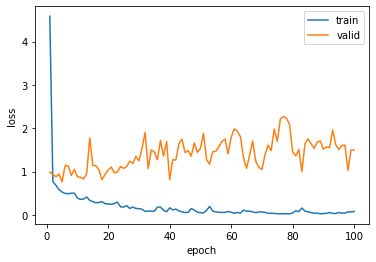

In [26]:
cnn4_trainer.learning_curve()

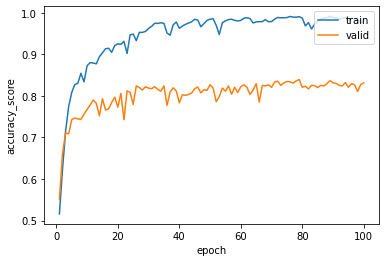

In [27]:
cnn4_trainer.learning_curve(y='accuracy_score')

In [28]:
sort_epochs(cnn4_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  prec_drinking  recall_chewing  \
157        0.839333   79.0      0.882550       0.866071        0.848387   
177        0.836667   89.0      0.883117       0.805128        0.877419   
155        0.836000   78.0      0.852201       0.820312        0.874194   
143        0.835333   72.0      0.857605       0.828947        0.854839   
149        0.834667   75.0      0.834862       0.811558        0.880645   
..              ...    ...           ...            ...             ...   
9          0.742667    5.0      0.752443       0.735211        0.745161   
5          0.710667    3.0      0.735593       0.655612        0.700000   
7          0.708667    4.0      0.682857       0.634783        0.770968   
3          0.660667    2.0      0.737374       0.538265        0.706452   
1          0.550667    1.0      0.720539       0.390244        0.690323   

     recall_drinking  
157         0.683099  
177         0.737089  
155         0.739437  
143    

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>